# 低通滤波器
低通就是地频率的波段能通过，低频段表现在图像上就是变化小的那部分，用于图像平滑。消除图像中的噪声成分叫作图像的平滑化或低通滤波。信号或图像的能量大部分集中在幅度谱的低频和中频段是很常见的，而在较高频段，感兴趣的信息经常被噪声淹没。因此一个能降低高频成分幅度的滤波器就能够减弱噪声的影响。

图像滤波的目的有两个:
- 抽出对象的特征作为图像识别的特征模式
- 为适应图像处理的要求，消除图像数字化时所混入的噪声

当然，在设计低通滤波器时，要考虑到滤波对图像造成的细节丢失等问题。平滑滤波是低频增强的空间域滤波技术。它的目的有两类
- 图像模糊
- 滤除图像噪

空间域的平滑滤波一般采用简单平均法进行，就是求邻近像元点的平均灰度值或亮度值。邻域的大小与平滑的效果直接相关，邻域越大平滑的效果越好，但邻域过大，平滑会使边缘信息损失的越大，从而使输出的图像变得模糊，因此需合理选择邻域的大小。关于滤波器，一种形象的比喻法是：我们可以把滤波器想象成一个包含加权系数的窗口，当使用这个滤波器平滑处理图像时，就把这个窗口放到图像之上，透过这个窗口来看我们得到的图像。

#1 线性滤波器
线性滤波器可以看做是用一个矩阵（滤波器的核）完整扫过源图片得到新图像，其中扫描的方式称为卷积

##1.1 均值滤波-邻域均值滤波
卷积核为奇数尺寸$3*3$，$5*5$等等,卷积核数字和为1($3*3$一般是全是1，然后乘以参数$\frac{1}{9}$)，主要作用就是模糊化图片
![images](../images/12/07.png)

图像的每个像素替换为相邻矩形内像素的平均值可以看出，卷积核越大，图像越模糊。$x_{22}$这个点经过均值滤波后的像素值如下计算
$$\begin{bmatrix}
x_{11}&x_{12}&x_{13}\\
x_{21}&x_{22}&x_{23}\\
x_{31}&x_{32}&x_{33}
\end{bmatrix} * \begin{bmatrix}
\frac{1}{9}&\frac{1}{9}&\frac{1}{9}\\
\frac{1}{9}&\frac{1}{9}&\frac{1}{9}\\
\frac{1}{9}&\frac{1}{9}&\frac{1}{9}
\end{bmatrix}=\frac{1}{9}(x_{11}+x_{12}+x_{13}+x_{21}+x_{22}+x_{23}+x_{31}+x_{32}+x_{33})$$

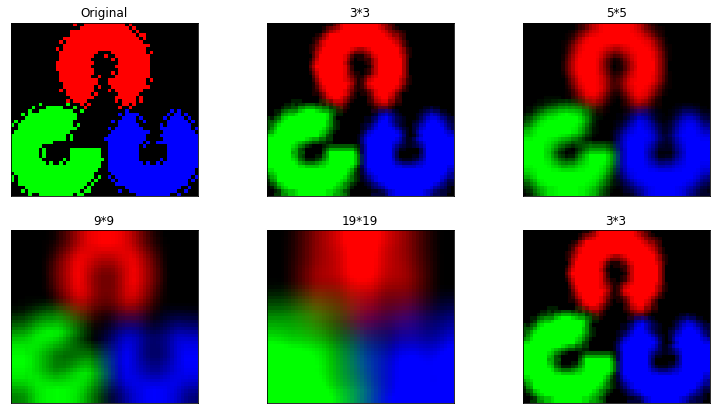

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('images/12/opencv-logo.png')

plt.figure(figsize=(13,7))
plt.subplot(231)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.xticks([]), plt.yticks([])

kernel = np.ones((3,3),np.float32)/9
dst = cv2.filter2D(img,-1,kernel)
plt.subplot(232),
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('3*3')
plt.xticks([]), plt.yticks([])

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(img,-1,kernel)
plt.subplot(233)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('5*5')
plt.xticks([]), plt.yticks([])

kernel = np.ones((10,10),np.float32)/100
dst = cv2.filter2D(img,-1,kernel)
plt.subplot(234)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('9*9')
plt.xticks([]), plt.yticks([])

kernel = np.ones((20,20),np.float32)/300
dst = cv2.filter2D(img,-1,kernel)
plt.subplot(235)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('19*19')
plt.xticks([]), plt.yticks([])

blur = cv2.blur(img,(3,3)) # blur就是做的平滑均值滤波
plt.subplot(236)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
plt.title('3*3')
plt.xticks([]), plt.yticks([])
plt.show()

##1.2 平滑高斯滤波-高斯低通滤波
卷积核为奇数尺寸，模拟人眼关注中心区域，有效去除高斯噪声。特点是，离关注中心越远，感受精度越模糊。公式$G_{\sigma}=\frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$。2D卷积可以拆分成两个相同的1D卷积.它的核是一个高斯分布的二维矩阵，中间大，向四周逐渐减小
$$\begin{bmatrix}
1&2&1\\
2&4&2\\
1&2&1
\end{bmatrix}=\begin{bmatrix}
1\\
2\\
1
\end{bmatrix} * \begin{bmatrix}
1&2&1
\end{bmatrix}$$
这样可以降低计算量，2D卷积需要进行$K*K$次计算，两个相同的1D卷积需要进行$2K$次计算，公式转换如下:$$\begin{align*}G_{\sigma} &=\frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}\\
& =(\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{x^2}{2\sigma^2}}) \bullet (\frac{1}{\sqrt{2\pi}\sigma}e^{-\frac{y^2}{2\sigma^2}})\end{align*}$$
16，就是高斯核所有9个数字的加和

生成高斯核的方法
```
def func(x,y,sigma=1):
    return 100*(1/(2*np.pi*sigma))*np.exp(-((x-2)**2+(y-2)**2)/(2.0*sigma**2))

suanzi1 = np.fromfunction(func,(5,5),sigma=5)
```

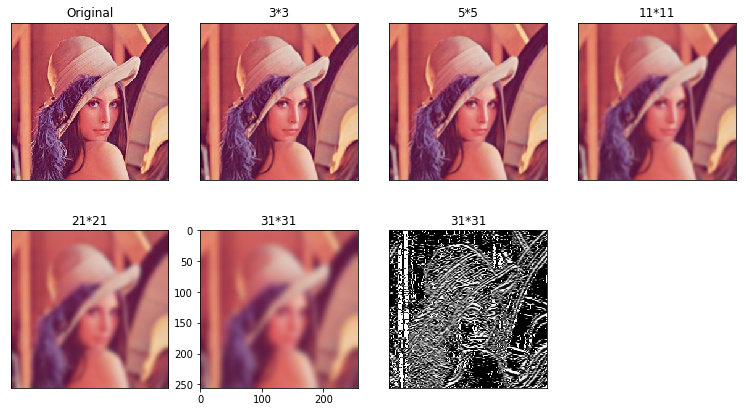

In [8]:
import cv2
from matplotlib import pyplot as plt
img = cv2.imread('images/12/Lena.png')

plt.figure(figsize=(13,7))
plt.subplot(241)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.xticks([]), plt.yticks([])

median = cv2.GaussianBlur(img,(3,3),0)
plt.subplot(242)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('3*3')
plt.xticks([]), plt.yticks([])

median = cv2.GaussianBlur(img,(5,5),0)
plt.subplot(243)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('5*5')
plt.xticks([]), plt.yticks([])

median = cv2.GaussianBlur(img,(11,11),0)
plt.subplot(244)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('11*11')
plt.xticks([]), plt.yticks([])

median = cv2.GaussianBlur(img,(21,21),0)
plt.subplot(245)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('21*21')
plt.xticks([]), plt.yticks([])

median = cv2.GaussianBlur(img,(31,31),0)
plt.subplot(246)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('31*31')

plt.xticks([]), plt.yticks([])
plt.show()

##1.3 自定义线性滤波器
比如现在需要锐化图像(使得图像的边缘变得清晰)，那可以很简单的设置一个核为$\begin{bmatrix}
0&-1&0\\
-1&3&-1\\
0&-1&0
\end{bmatrix}$

#2 非线性滤波器

##2.1 中值滤波
卷积核为奇数尺寸，卷积核内部像素值从小到大排序，取中间值作为卷积输出，可以有效去除椒盐噪声![images](../images/12/08.png)
原图片左上$3*3$的9个数，做从小到大排列，然后放入卷积核，输出取中间数5为输出,然后向右移动一个像素，找到9个数，继续从小到大排列，放入卷积核，取出中间数作为输出
![images](../images/12/09.png)

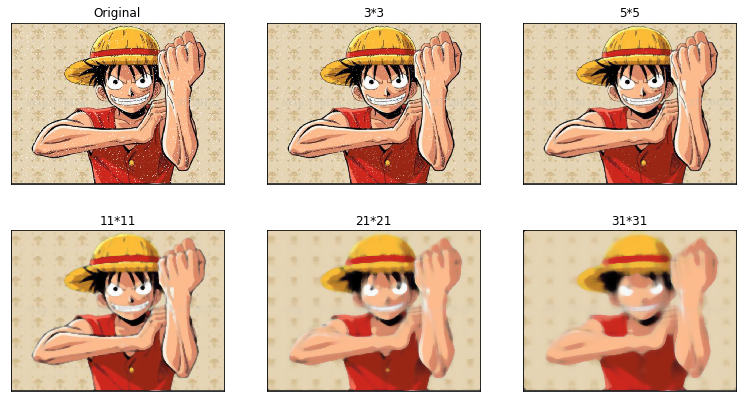

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('images/12/Noise.png')

plt.figure(figsize=(13,7))
plt.subplot(231)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.xticks([]), plt.yticks([])

median = cv2.medianBlur(img,3)
plt.subplot(232)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('3*3')
plt.xticks([]), plt.yticks([])

median = cv2.medianBlur(img,5)
plt.subplot(233)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('5*5')
plt.xticks([]), plt.yticks([])

median = cv2.medianBlur(img,11)
plt.subplot(234)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('11*11')
plt.xticks([]), plt.yticks([])

median = cv2.medianBlur(img,21)
plt.subplot(235)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('21*21')
plt.xticks([]), plt.yticks([])

median = cv2.medianBlur(img,31)
plt.subplot(236)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('31*31')
plt.xticks([]), plt.yticks([])
plt.show()

##2.2 双边滤波-Bilateral Filtering
双边滤波是一种可以保边去噪的滤波器。之所以可以达到此去噪效果，是因为滤波器是由两个函数构成。一个函数是由几何空间距离决定滤波器系数。另一个由像素差值决定滤波器系数。可以与其相比较的两个filter：高斯滤波器和α-截尾均值滤波器（去掉百分率为α的最小值和最大之后剩下像素的均值作为滤波器）

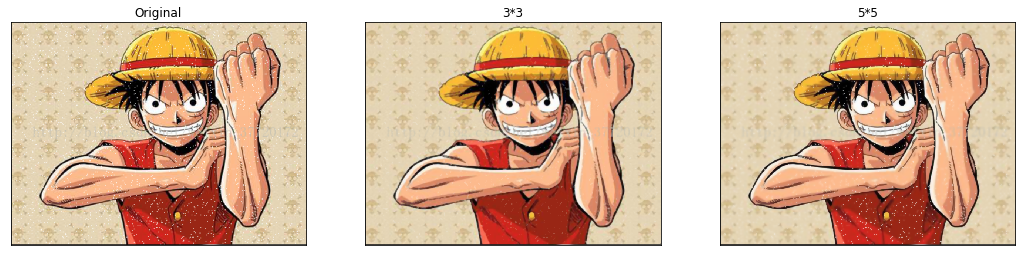

In [5]:
import cv2

import numpy as np
from matplotlib import pyplot as plt
img = cv2.imread('images/12/Noise.png')

plt.figure(figsize=(18,7))
plt.subplot(131)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original')
plt.xticks([]), plt.yticks([])

median = cv2.medianBlur(img,5)
plt.subplot(132)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('3*3')
plt.xticks([]), plt.yticks([])

blur = cv2.bilateralFilter(img,9,75,75)
plt.subplot(133)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
plt.title('5*5')
plt.xticks([]), plt.yticks([])

plt.show()

#3 对比
低通滤波主要包括：均值滤波，中值滤波，高斯低通滤波，保边滤波。中值滤波对于去除椒盐噪声效果明显，这是由于一个例外的黑点或白点像素出现在一个相邻区域时，通常不会被选为中值，因为它们代表的是0或255两个极端，因此这些噪声点总会被替换为某个相邻像素的值，而均值滤波和高斯滤波均会引入噪点信息，噪点处的像素值会极大地影响区域的结果，因此无法很好地滤除这一类噪声.由于中值滤波器是非线性的，因此它无法表示为一个核矩阵。此外，中值滤波器还有保留边缘锐利度的优点。但是缺点是相同区域中的纹理细节也被滤除
- 线性滤波器：均值滤波，高斯滤波.
- 非线性滤波器：中值滤波，保边滤波

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 255 + 1) instead
  del sys.path[0]
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: This function is deprecated. Please call randint(0, 255 + 1) instead
  
/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  from ipykernel import kernelapp as app


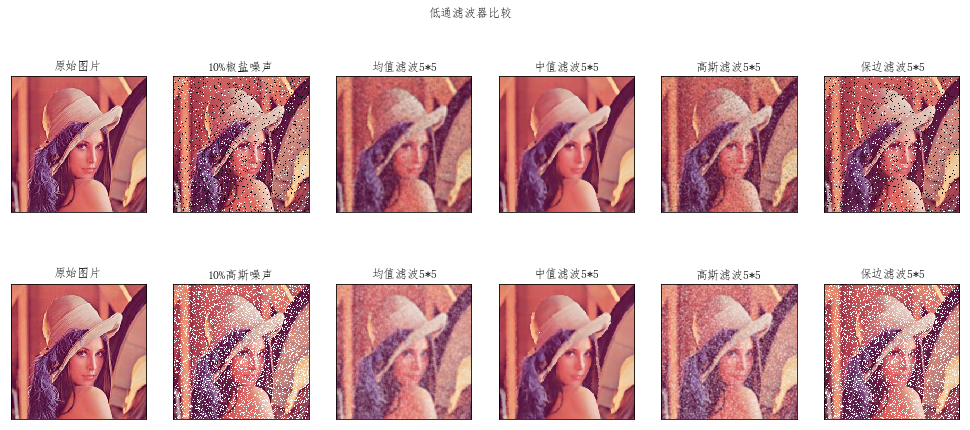

In [27]:
import cv2
import matplotlib as mpl
from numpy import *
from matplotlib import pyplot as plt
img = cv2.imread('images/12/Lena.png')

mpl.rcParams['font.sans-serif'] = ['FangSong'] # 指定默认字体
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
def SaltAndPepper(src,percetage):
    NoiseImg=src
    NoiseNum=int(percetage*src.shape[0]*src.shape[1])
    for i in range(NoiseNum):
        randX=random.random_integers(0,src.shape[0]-1)
        randY=random.random_integers(0,src.shape[1]-1)
        if random.random_integers(0,1)==0:
            NoiseImg[randX,randY]=0
        else:
            NoiseImg[randX,randY]=255
    return NoiseImg
def addGaussianNoise(image,percetage): #定义添加高斯噪声的函数 
    G_Noiseimg = image 
    G_NoiseNum=int(percetage*image.shape[0]*image.shape[1]) 
    for i in range(G_NoiseNum): 
        temp_x = np.random.randint(0,image.shape[0]) 
        temp_y = np.random.randint(0,image.shape[1]) 
        G_Noiseimg[temp_x][temp_y] = 255 
    
    return G_Noiseimg

plt.figure(figsize=(17,7), facecolor='w')
plt.subplot(261)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('原始图片')
plt.xticks([]), plt.yticks([])

image = img.copy()
NoiseImg=SaltAndPepper(image,0.1)
plt.subplot(262)
plt.imshow(cv2.cvtColor(NoiseImg, cv2.COLOR_BGR2RGB))
plt.title('10%椒盐噪声')
plt.xticks([]), plt.yticks([])

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(NoiseImg,-1,kernel)
plt.subplot(263)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('均值滤波5*5')
plt.xticks([]), plt.yticks([])

median = cv2.medianBlur(NoiseImg,5)
plt.subplot(264)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('中值滤波5*5')
plt.xticks([]), plt.yticks([])

median = cv2.GaussianBlur(NoiseImg,(5,5),0)
plt.subplot(265)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('高斯滤波5*5')
plt.xticks([]), plt.yticks([])

blur = cv2.bilateralFilter(NoiseImg,9,75,75)
plt.subplot(266)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
plt.title('保边滤波5*5')
plt.xticks([]), plt.yticks([])

plt.subplot(267)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('原始图片')
plt.xticks([]), plt.yticks([])

NoiseImg=addGaussianNoise(img,0.2)
plt.subplot(268)
plt.imshow(cv2.cvtColor(NoiseImg, cv2.COLOR_BGR2RGB))
plt.title('10%高斯噪声')
plt.xticks([]), plt.yticks([])

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(NoiseImg,-1,kernel)
plt.subplot(269)
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.title('均值滤波5*5')
plt.xticks([]), plt.yticks([])

median = cv2.medianBlur(NoiseImg,5)
plt.subplot(2,6,10)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('中值滤波5*5')
plt.xticks([]), plt.yticks([])

median = cv2.GaussianBlur(NoiseImg,(5,5),0)
plt.subplot(2,6, 11)
plt.imshow(cv2.cvtColor(median, cv2.COLOR_BGR2RGB))
plt.title('高斯滤波5*5')
plt.xticks([]), plt.yticks([])

blur = cv2.bilateralFilter(NoiseImg,9,75,75)
plt.subplot(2,6,12)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))
plt.title('保边滤波5*5')
plt.xticks([]), plt.yticks([])

plt.suptitle('低通滤波器比较')
plt.show()

#4 应用-图像污点修复